In [0]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d

from torch.utils.data import DataLoader, Dataset, sampler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage


import segmentation_models_pytorch as smp


from albumentations import (
                            PadIfNeeded,
                            HorizontalFlip,
                            VerticalFlip,    
                            CenterCrop,    
                            Crop,
                            Compose,
                            RandomRotate90,
                            RandomBrightnessContrast,
                            ElasticTransform,
                            GridDistortion, 
                            OpticalDistortion,
                            RandomSizedCrop,
                        )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
!cp /content/drive/"My Drive"/segmentation/data.tar.xz /content/
!tar -xf /content/data.tar.xz -C /content/

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [0]:
class SegmentationDataset(Dataset):   
    def __init__(self, image_folder_name, mask_folder_name, augmentation =None, transform = None):
        
        self.image_paths  = np.array(np.sort([image_folder_name + "/" + i for i in os.listdir(image_folder_name)]))
        self.mask_paths  = np.array(np.sort([mask_folder_name + "/"+ i for i in os.listdir(mask_folder_name)]))
        self.transform = transform
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], 0)
        mask = cv2.imread(self.mask_paths[idx], 0)

        # image = cv2.resize(image, (256,256))
        # mask = cv2.resize(mask, (256,256))


        mask[mask > 0] = 1

        augmented  = self.augmentation(image = image, mask = mask)

        image = augmented["image"]
        mask = augmented["mask"]

        # image = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

        # print(image, mask)
        return self.transform(image), self.transform(mask)
    
    def __len__(self):
        return len(self.image_paths)
        

train_dataset = SegmentationDataset("data/images", 
                                    "data/masks",
                                    augmentation =  Compose([
                                                            # ElasticTransform(p=1, alpha=50, sigma=80 * 0.05, alpha_affine=120 * 0.03),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            GridDistortion(p=1),
                                                            RandomBrightnessContrast( p=0.5)           
                                                            ]),

                                    transform = transforms.Compose([ 
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256)),
                                                                    ToTensor()
                                                                ])
                                    )

In [214]:
train_batch_size = 3
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
print(len(train_data_loader))

2


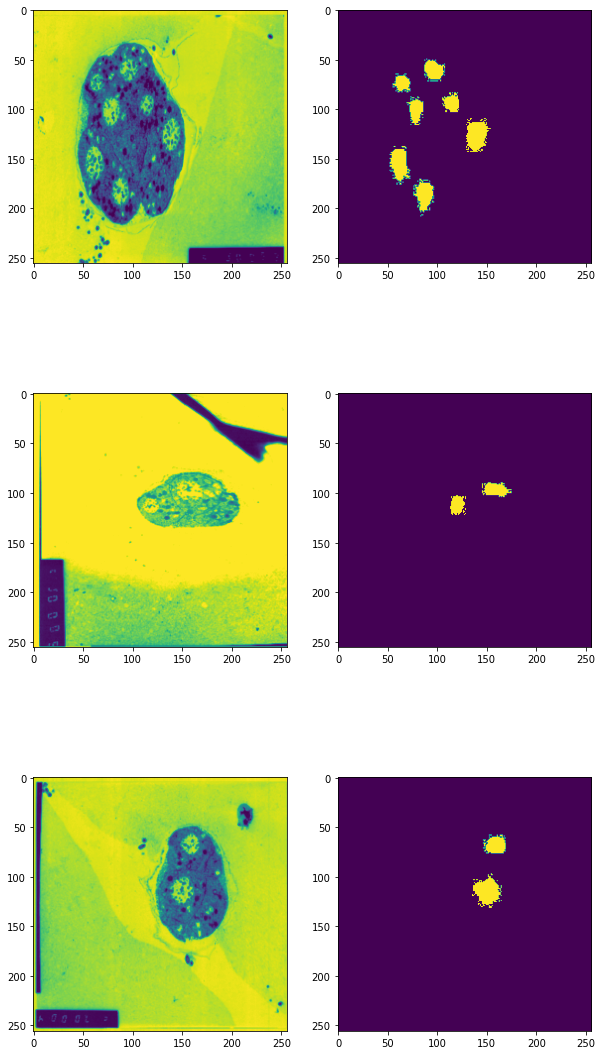

In [226]:
batch  = next(iter(train_data_loader))

images, masks = batch
fig, ax = plt.subplots(train_batch_size, 2, figsize = (10,20))


for i in range(train_batch_size):

    ax[i][0].imshow(images[i][0])
    ax[i][1].imshow(masks[i][0])

In [0]:
# Based on https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/unet.py#L19
class UNetMini(Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        # Use padding 1 to mimic `padding='same'` in keras,
        # use this visualization tool https://ezyang.github.io/convolution-visualizer/index.html
        self.block1 = Sequential(
            Conv2d(1, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)
        return out5



In [310]:
# Use gpu for training if available else use cpu

model = UNetMini(2).to(device)
learning_rate = 0.0005
epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')# Here is the loss and optimizer definition
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")


10 epochs, 2 total_steps per epoch


In [311]:
losses = []

for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_data_loader, 1):
        images = images.to(device)
        
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        losses.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print (f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():4f}")

Epoch [1/10], Loss: 3.476285
Epoch [2/10], Loss: 3.471383
Epoch [3/10], Loss: 3.462119
Epoch [4/10], Loss: 3.413583
Epoch [5/10], Loss: 3.240909
Epoch [6/10], Loss: 2.676828
Epoch [7/10], Loss: 1.074104
Epoch [8/10], Loss: 0.042913
Epoch [9/10], Loss: 0.003511
Epoch [10/10], Loss: 0.000070


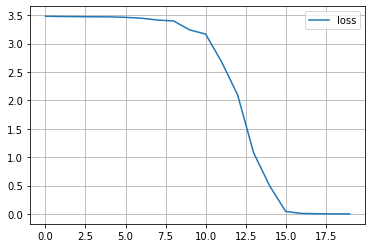

In [312]:
plt.plot(losses, label = "loss")
plt.grid()
plt.legend()